In [1]:
using DynamicalSystems
using DifferentialEquations
using OrdinaryDiffEq
using StaticArrays
using Statistics
using CairoMakie
using JLD

In [2]:
function sigma(x)
    return 1.0 / ( 1.0 + exp( -10.0 * ( x  - ( - 0.25 ) ) ) )
end

function HR(u, p, t)
        
    a, b, c, d, s, xr, r,  I, vs, k1, k2, el_link  = p
    x1, y1, z1, x2, y2, z2 = u
    
    du1 = y1 + b * x1 ^ 2 - a * x1 ^3 - z1 + I - k1 * ( x1 - vs ) * sigma(x2) + el_link * ( x2 - x1 )
    du2 = c - d * x1 ^2 - y1
    du3 = r * ( s * ( x1 - xr ) - z1 )
    
    du4 = y2 + b * x2 ^ 2 - a * x2 ^3 - z2 + I - k2 * ( x2 - vs ) * sigma(x1) + el_link * ( x1 - x2 )
    du5 = c - d * x2 ^2 - y2
    du6 = r * ( s * ( x2 - xr ) - z2 )
    return SVector(du1, du2, du3,
                    du4, du5, du6)
end
Hs(x, k) = Statistics.mean(x) + k * Statistics.std(x)

Hs (generic function with 1 method)

In [4]:
function peaks(x)
    peaks_ = Float64[]
    len_ = length(x)
    for i in range(2, len_ - 1, step = 1)
        if x[i-1] < x[i] > x[i+1]
            push!(peaks_, x[i])
        end
    end
    return peaks_
end

peaks (generic function with 1 method)

In [47]:
tspan = (0., 300000.)

a = 1.
b = 3.
c = 1.
d = 5.
xr = -1.6
r = 0.01
s = 5.
I = 4.
xv = 2.

k1 = -0.17
k2 = -0.17
k = 0

0

In [48]:
p = SA[a, b, c, d, s, xr, r, I, xv, k1, k2, k]
condition = SA[-1.3708880285256102
 -8.022011143224757
  4.3093369397057115
 -0.7483763647564559
 -1.8529391589460256
  4.142716799658893]

6-element SVector{6, Float64} with indices SOneTo(6):
 -1.3708880285256102
 -8.022011143224757
  4.3093369397057115
 -0.7483763647564559
 -1.8529391589460256
  4.142716799658893

In [49]:
prob = ODEProblem(HR, condition, tspan, p)

ODEProblem with uType SVector{6, Float64} and tType Float64. In-place: false
timespan: (0.0, 300000.0)
u0: 6-element SVector{6, Float64} with indices SOneTo(6):
 -1.3708880285256102
 -8.022011143224757
  4.3093369397057115
 -0.7483763647564559
 -1.8529391589460256
  4.142716799658893

In [50]:
sol = solve(prob, Vern9(), adaptive = false, dt = 0.1,  abstol = 1e-14, reltol = 1e-14, maxiters = 50000000);

In [51]:
xsum = sol[1, :] + sol[4, :];
println("before: ", length(xsum))

xsum = xsum[floor(Int, length(xsum) / 4):end ]
println("after: ", length(xsum))

before: 3000001
after: 2250002


In [52]:
Hs1 = Hs(xsum, 6)
length(xsum), Hs1

(2250002, 2.444994075008113)

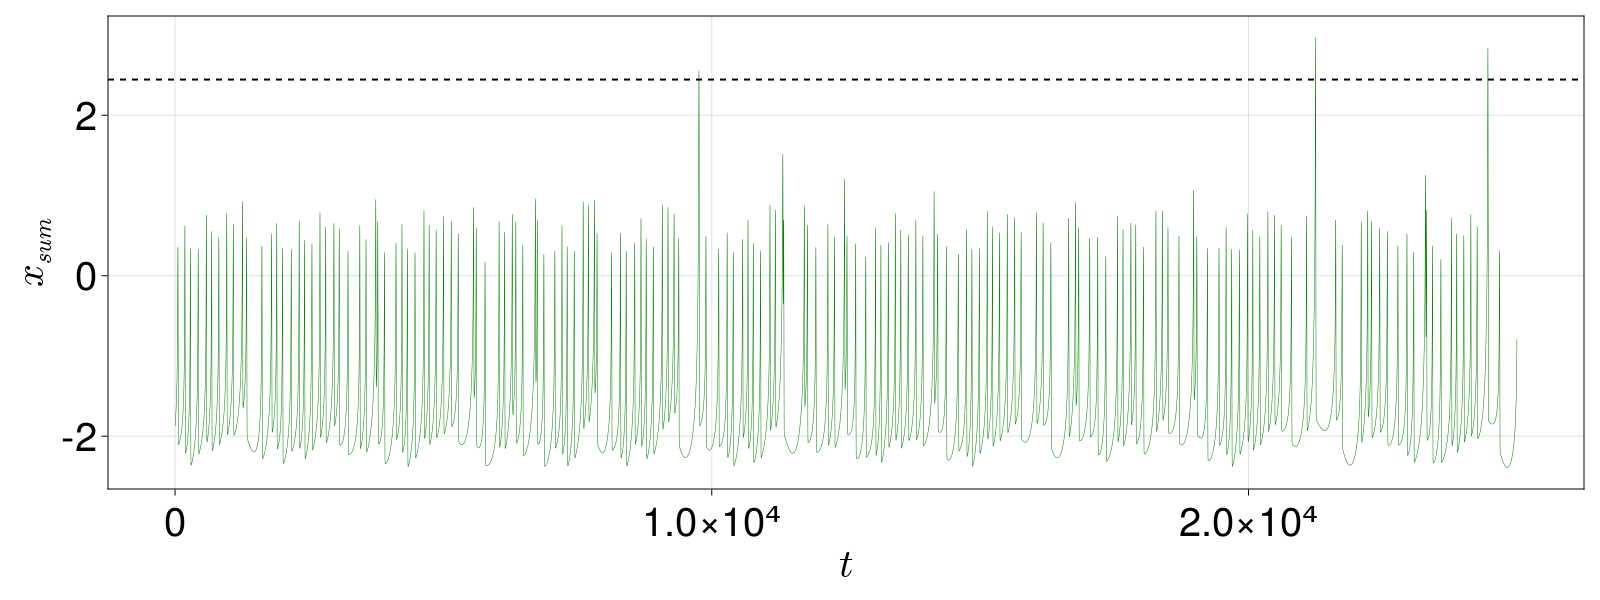

In [53]:
f = Figure(resolution = (1600, 600), fontsize = 40)
ax = Axis(f[1, 1], xlabel = L"t", ylabel = L"x_{sum}")

ts, tf = 20000, 45000

lines!(ax, xsum[ts:tf], linewidth = 0.5, color = "green")

hlines!(Hs1, color = "black", linewidth = 2.0, linestyle = :dash)

f

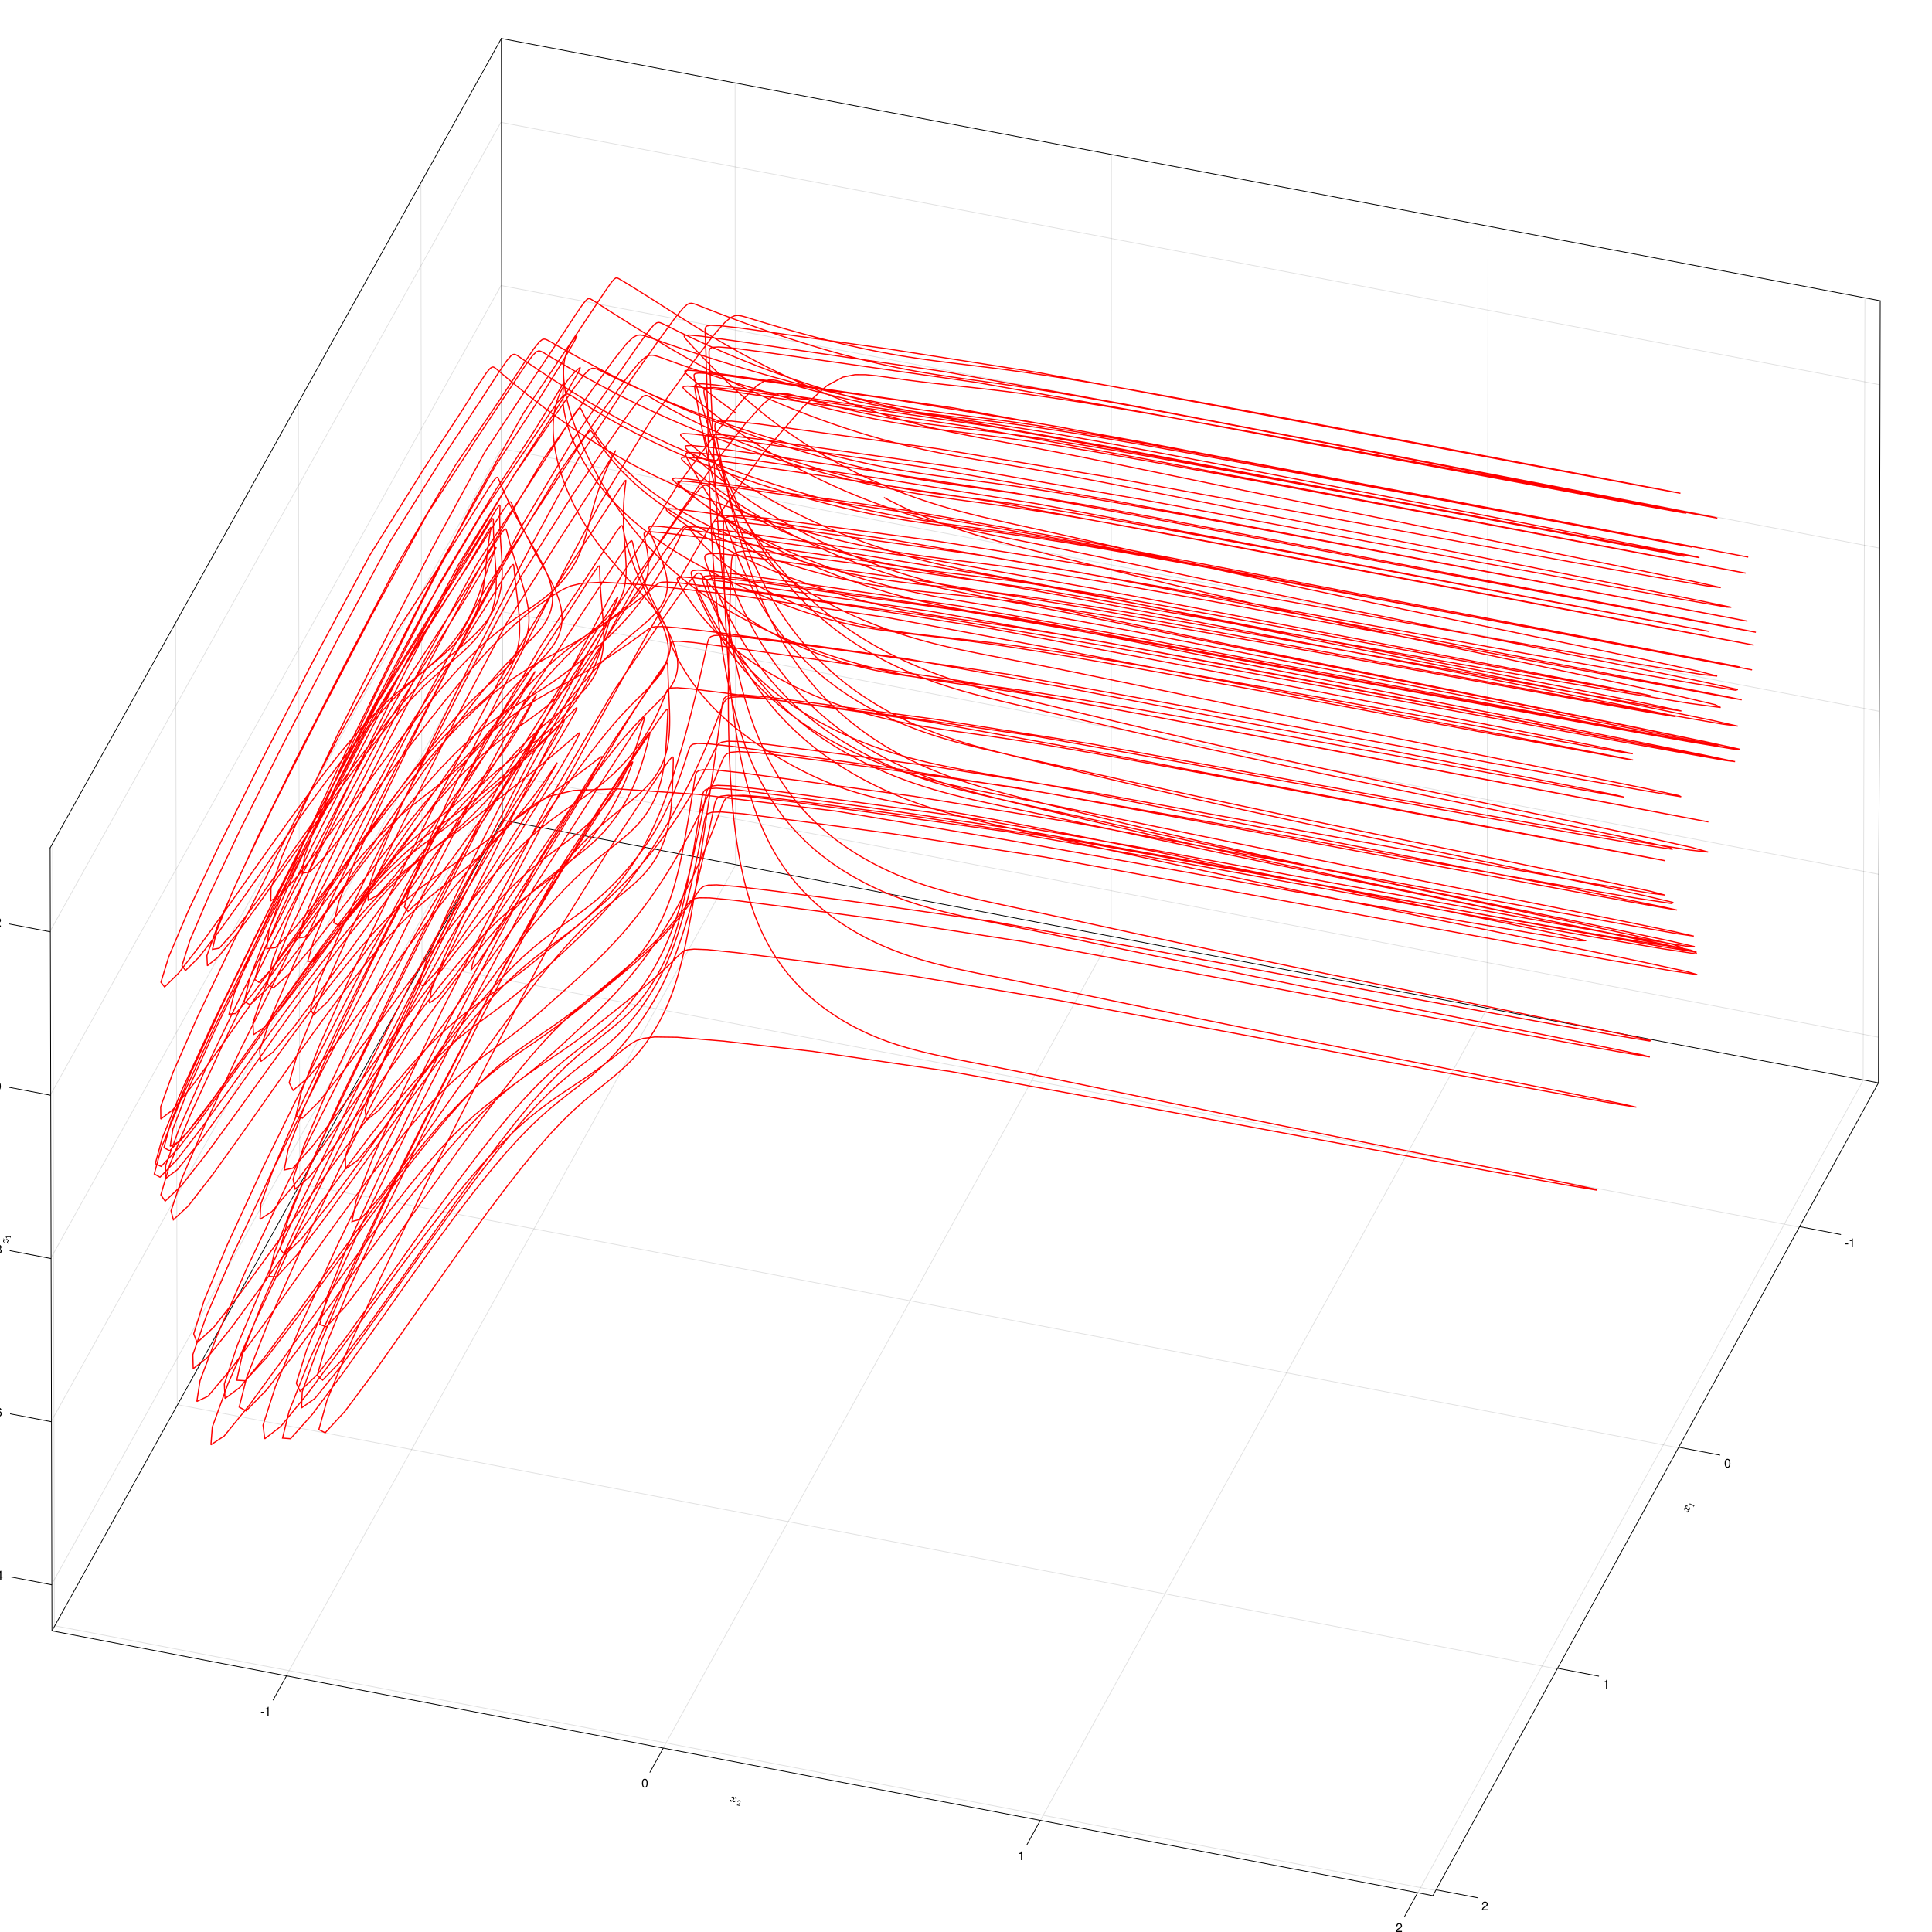

In [54]:
f = Figure(resolution = (2500, 2500), dpi = 300)
ax = Axis3(f[1, 1], xlabel = L"x_1", ylabel = L"x_2", zlabel = L"z_1", elevation = 0.2pi, azimuth = 0.1pi)

ts, tf = 20000, 35000

lines!(ax, sol[1, ts:tf], sol[4, ts:tf], sol[3, ts:tf], linewidth = 1.5, color = "red")

f

In [55]:
ds = ContinuousDynamicalSystem(HR, condition, p)

6-dimensional continuous dynamical system
 state:       [-1.37089, -8.02201, 4.30934, -0.748376, -1.85294, 4.14272]
 rule f:      HR
 in-place?    false
 jacobian:    ForwardDiff
 parameters:  [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, …, 4.0, 2.0, -0.17, -0.17, 0.0]

In [56]:
t = 300000.0
Ttr = t / 2

150000.0

In [57]:
length(range(0.0, t, step = 0.01))

30000001

In [59]:
LES = lyapunovspectrum(ds, t; Ttr = Ttr, Δt = 0.1,
    diffeq = (alg = Vern9(), abstol = 1e-14, reltol = 1e-14, maxiters = 50000000 ))
    

6-element Vector{Float64}:
   0.015412662705733667
   0.0058390174856435655
  -2.3030728612465102e-5
  -0.02582531329342321
  -6.448707064477369
 -11.486637002737298